# ML @ AMSI Bioinfosummer

This is a notebook containing some code for ML @ AMSI Bioinfosummer

In [10]:
import wget # to download from zenodo
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


print("Here is some code")


Here is some code


## Datasets
We're going to load a diabetes dataset with few hundred features and try to predict outcome one year into the future. Specifically, our outcome is whether a certain measure is over 100. This example is very poor right now, so I'll see if I can find a COVID one. 

In [11]:
X,y=datasets.load_diabetes(return_X_y=True)
y=y>100
print(X.shape, y.shape)


(442, 10) (442,)


We'll have a whole section on exploratory plots as that is always important. What is the data we have? What are the relationships? Worth understanding before we get started. 

## Experimental 

What if we just build model on entire dataset on the entire dataset?

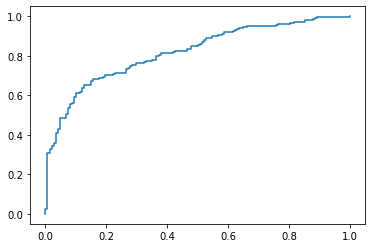

In [12]:
clf = LogisticRegression(penalty='l2').fit(X, y)
pred_all=clf.predict_proba(X)[:,1]
plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(y, pred_all)
auc = metrics.roc_auc_score(y, pred_all)
plt.plot(fpr,tpr,label="Train, auc={:.2f}".format(auc))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train.shape, y_train.shape

((397, 10), (397,))

In [14]:
X_test.shape, y_test.shape

((45, 10), (45,))

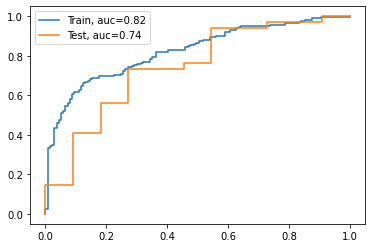

In [15]:
clf = LogisticRegression(penalty='l2').fit(X_train, y_train)
#clf.score(X_test, y_test)


pred_train=clf.predict_proba(X_train)[:,1]
pred_test=clf.predict_proba(X_test)[:,1]


plt.figure(0).clf()


fpr, tpr, thresh = metrics.roc_curve(y_train, pred_train)
auc = metrics.roc_auc_score(y_train, pred_train)
plt.plot(fpr,tpr,label="Train, auc={:.2f}".format(auc))


fpr, tpr, thresh = metrics.roc_curve(y_test, pred_test)
auc = metrics.roc_auc_score(y_test, pred_test)
plt.plot(fpr,tpr,label="Test, auc={:.2f}".format(auc))

plt.legend(loc=0)

In [16]:
# print required packages with version
%load_ext watermark

#python, packages and machine characteristics
%watermark -v -m -p wget,pandas,numpy,sklearn,matplotlib,watermark

#date
print (" ")
%watermark -u -n -t -z

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.7.8
IPython version      : 7.25.0

wget      : 3.2
pandas    : 1.2.5
numpy     : 1.21.0
sklearn   : 0.24.2
matplotlib: 3.4.3
watermark : 2.2.0

Compiler    : Clang 10.0.1 
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

 
Last updated: Mon Nov 15 2021 09:37:44AEDT

